In [8]:
import os
import torch
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [9]:
from torch_geometric.datasets import KarateClub

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Using device: cuda
Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [10]:
# Take the only graph in the data
data = dataset[0]
print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
# COO format, tuple of two node indices (source, desitination)
# commonly used for representing sparse matrices
# only non-zero value in the adjacency matrix A
# pyG consider only undirected graph
edge_index = data.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

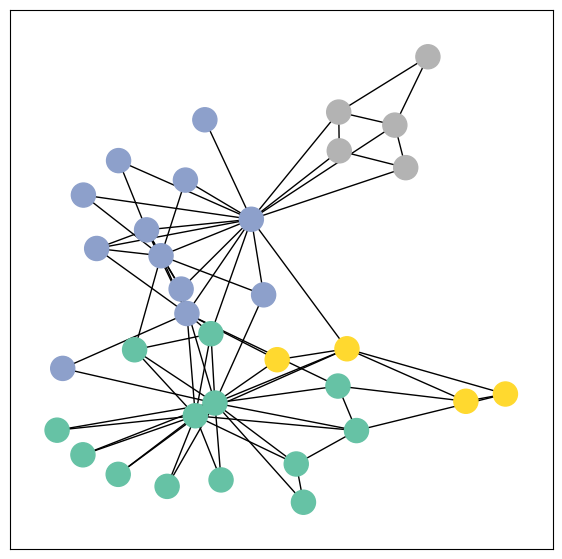

In [12]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [13]:
print(data.y+1)
print(data.train_mask)

tensor([2, 2, 2, 2, 4, 4, 4, 2, 1, 2, 4, 2, 2, 2, 1, 1, 4, 2, 1, 2, 1, 2, 1, 1,
        3, 3, 1, 1, 3, 1, 1, 3, 1, 1])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


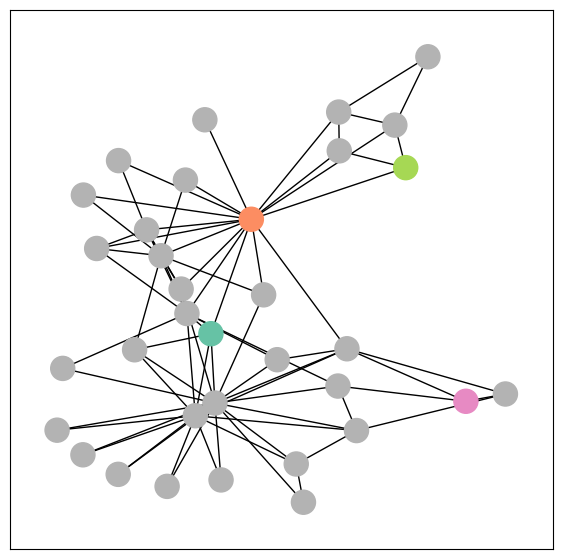

In [14]:
default_value = 5
masked_y = torch.where(data.train_mask, data.y, torch.tensor(default_value))
G_masked = to_networkx(data, to_undirected=True)
visualize_graph(G, color=masked_y)

# Implementing GNN
A simple Gnn layer takes the sum of all the neighbours (which form a vector of 34) and multiply it to W, a weight matrix (n, 34). x^+1 = W^+1 * Sum(Neig(x)/c)

In [19]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4) # 34, 4
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes) # 2, 4

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape: [34, 2]


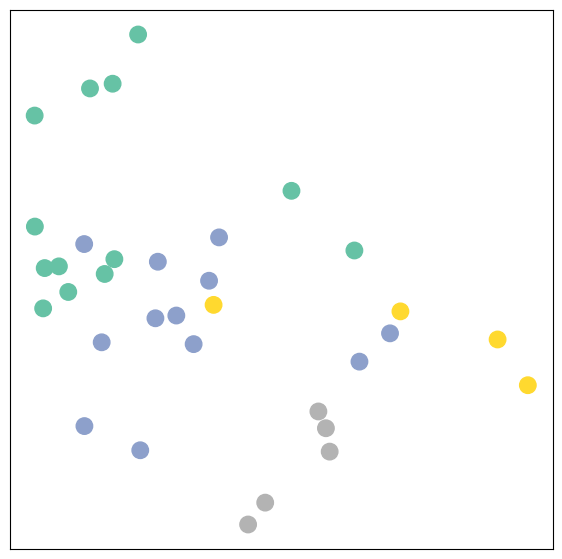

In [20]:
# Visualize the 2d embeding

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph. Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized completely at random and we have not yet performed any training so far! This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

In [71]:
# Train the model with the 4 examples
# We simply train against one node per class, 
# but are allowed to make use of the complete input graph data.

In [23]:
import time

model = GCN().to(device)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    data = data.to(device)
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    print(out[data.train_mask])
    print(data.y[data.train_mask])
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out
 
for epoch in range(1001):
    loss, h, out = train(data)
    #if epoch % 10 == 0:
        #visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        #time.sleep(0.3)
    predicted_y = out

tensor([[-0.1800,  0.6862,  0.1598,  0.1413],
        [-0.1999,  0.6750,  0.1442,  0.1249],
        [-0.1940,  0.6523,  0.1278,  0.0997],
        [-0.1739,  0.7036,  0.1758,  0.1624]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([1, 3, 0, 2], device='cuda:0')
tensor([[-0.1789,  0.6430,  0.1404,  0.1114],
        [-0.1918,  0.6500,  0.1418,  0.1172],
        [-0.1833,  0.6174,  0.1169,  0.0809],
        [-0.1663,  0.6705,  0.1683,  0.1457]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([1, 3, 0, 2], device='cuda:0')
tensor([[-0.1791,  0.6010,  0.1183,  0.0820],
        [-0.1847,  0.6255,  0.1381,  0.1097],
        [-0.1714,  0.5829,  0.1051,  0.0621],
        [-0.1578,  0.6387,  0.1603,  0.1302]], device='cuda:0',
       grad_fn=<IndexBackward0>)
tensor([1, 3, 0, 2], device='cuda:0')
tensor([[-0.1809,  0.5611,  0.0940,  0.0525],
        [-0.1787,  0.6020,  0.1333,  0.1024],
        [-0.1586,  0.5490,  0.0921,  0.0422],
        [-0.1492,  0.6077,  0.1513,  0.1150

In [24]:
predicted_y[data.train_mask]
max_indices = torch.argmax(predicted_y, dim=1)
print(max_indices[data.train_mask])

tensor([1, 3, 0, 2], device='cuda:0')


In [25]:
data.y[data.train_mask]

tensor([1, 3, 0, 2], device='cuda:0')

While we compute node embeddings for all of our nodes, we only make use of the training nodes for computing the loss.


In [26]:
#test the entire network
loss_all = criterion(predicted_y, data.y)
print(loss_all)

tensor(0.7676, device='cuda:0', grad_fn=<NllLossBackward0>)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

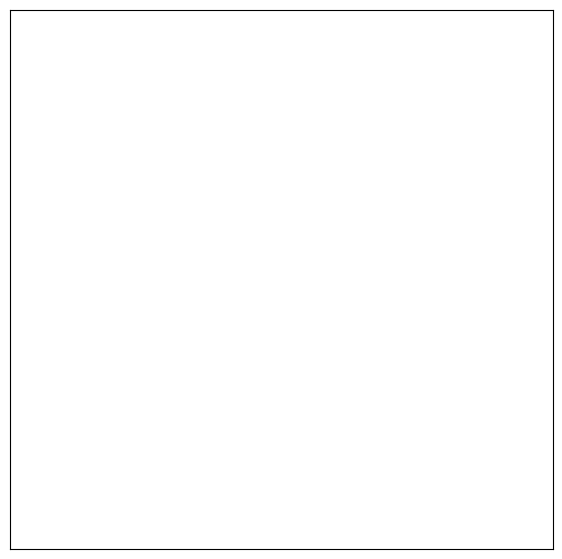

In [27]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)
visualize_graph(G, color=max_indices)